# Udacity Self-Driving Car Nanodegree
---
## Advanced Lane Finding Project
### The pipeline for the project is as follows:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Calibrate camera and apply a distortion correction to raw images.
* Use methods (i.e. color transforms, gradients) to create a binary image containing likely lane pixels.
* Apply perspective transform to show a bird's eye view of the road for each image.
* Identify left and right lane lines and add a line of fit (i.e. spline, polynomial).
* Calculate the radius of curvature for the line of fit and the position of the vehicle with respect to the center of the lane.
* Output original image with radius/position calculations and lane estimations.
---
### Imports

In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

---
### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

The corners of the chessboards in the calibration photos are found using the OpenCV functions `findChessboardCorners` and `drawChessboardCorners`.  These corner locations are then used in the OpenCV function `calibrateCamera` to get the camera calibration matrix and distortion coefficients.  Lastly, the OpenCV function `undistort` removes distortion from our test image using the calculated distortion coefficients.

In [ ]:
# prepare object points
nx = 9
ny = 6

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (7,5,0)
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# To show all images
fig, axs = plt.subplots(4, 5, figsize= (16, 9))
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)

###### Only axis shown if corners are not found.
---
### Calibrate camera and apply a distortion correction to raw images

In [ ]:
# Read in an image
img = cv2.imread('./camera_cal/calibration1.jpg')

# Calibrate camera and correct distortion
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx), mtx, dist

undist, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
### Distortion-Corrected Test Image Example

In [ ]:
example_img = cv2.cvtColor(cv2.imread('./test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
example_undist, mtx, dist = cal_undistort(example_img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(example_img)
ax1.set_title('Original Image', fontsize = 50)
ax2.imshow(example_undist)
ax2.set_title('Undistorted Image', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
### Use methods (i.e. color transforms, gradients) to create a binary image containing likely lane pixels.

Playing around with different color spaces and gradients, I found that the L channel in the HLS color space found the white lane lines very well while the B channel in the LAB color space found the yellow lane lines very well.  Combining these two thresholds created a very accurate and quiet binary image of the road's lane lines.

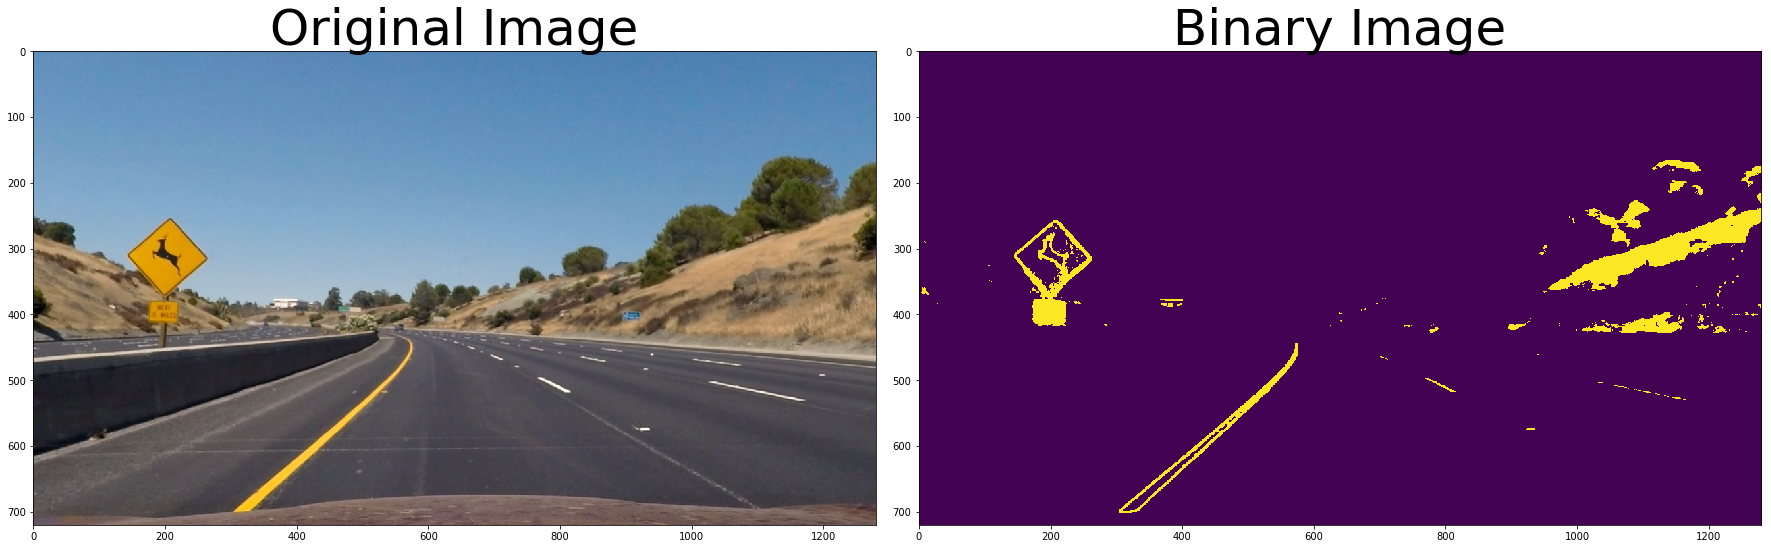

In [5]:
# Edit this function to create your own pipeline.
def binary_image(img, b_thresh=(155, 200), l_thresh=(225, 255)):
    img = np.copy(img)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    l_channel = hls[:,:,1]
    b_channel = lab[:,:,2]
    
    
    # Threshold color channel
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    
    # Stack each channel
    color_binary = np.zeros_like(l_binary)
    color_binary[(l_binary == 1) | (b_binary == 1)] = 1
    return color_binary
    
bin_img = binary_image(example_undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(example_undist)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(bin_img)
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
### Apply perspective transform to show a bird's eye view of the road for each image.

Using the OpenCV function `getPerspectiveTransform` with inputs of the manually selected source and destination perspectives, a matrix was calculated that, when applied to the OpenCV function `warpPerspective`, outputs the desired perspective transform.

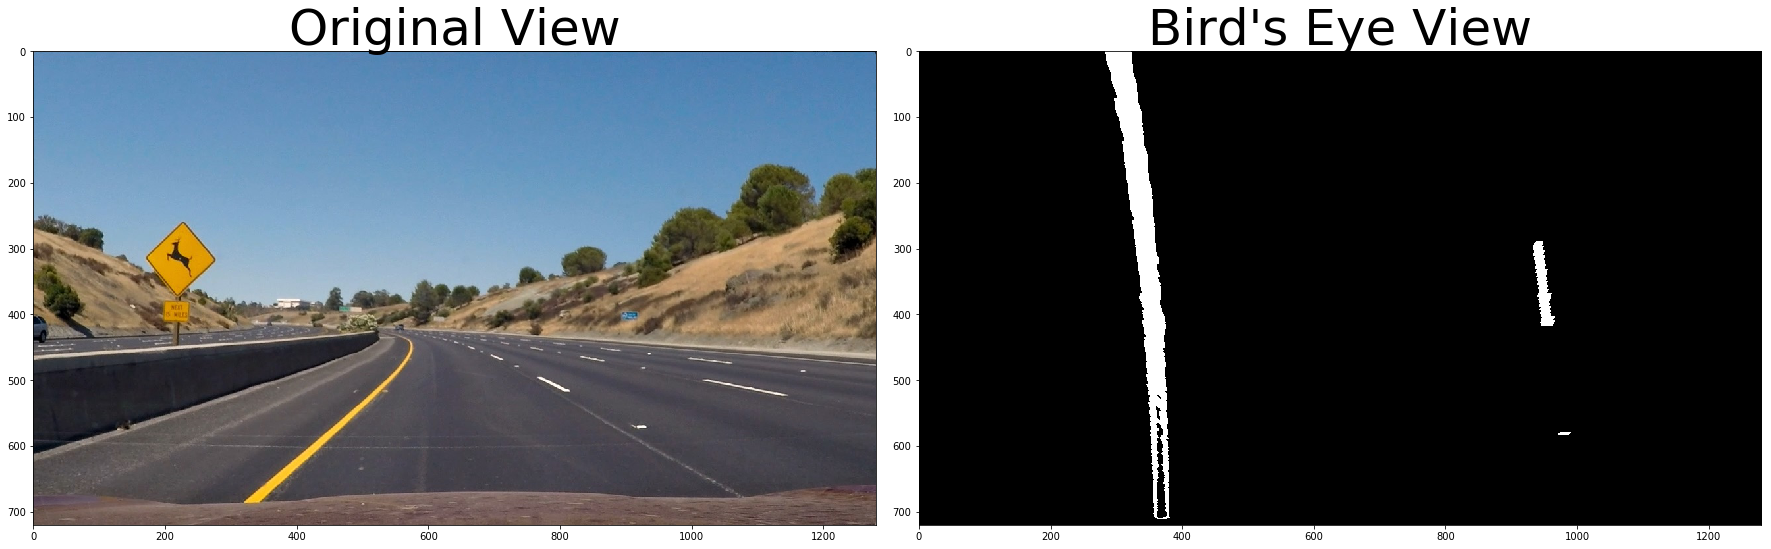

In [16]:
# Vertices extracted manually for performing a perspective transform
src = np.float32([[220, 720], [1110, 720], [722, 470], [570, 470]])

# Destination points are chosen such that straight lanes appear parallel in the transformed image.
dest = np.float32([[320,720], [920, 720], [920, 1], [320, 1]])

def unwarp(img, src, dest):
    M = cv2.getPerspectiveTransform(src, dest)
    M_inv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(img, M, (example_undist.shape[1], example_img.shape[0]))
    return warped, M, M_inv

warped, M, M_inv = unwarp(bin_img, src, dest)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(example_img)
ax1.set_title('Original View', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Bird\'s Eye View', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
### Identify left and right lane lines and add a line of fit (i.e. spline, polynomial).

Using the Bird's Eye View of the binary image, a histogram of vertical frequency of 1's was created to determine where the lane lines are.  Using the histogram peaks, a sliding window technique is applied to find the locations of the line pixels.  Lastly, a search from prior technique is used to efficiently find the line pixels.  Using the pixel locations, a polynomial line is fit to the data using `numpy.polyfit()`.

#### Histogram

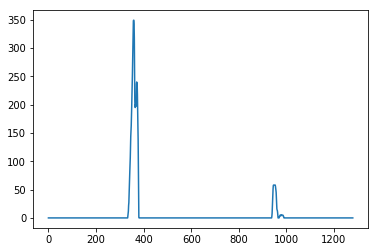

In [19]:
def hist(img):
    # Grab only the bottom half of the image
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)

#### Sliding Window

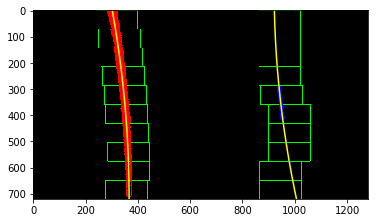

In [18]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    nwindows = 10
    # Width of the windows +/- margin
    margin = 80
    # Minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        y_low = binary_warped.shape[0] - (window + 1) * window_height
        y_high = binary_warped.shape[0] - window * window_height
        xleft_low = leftx_base - margin
        xleft_high = leftx_base + margin
        xright_low = rightx_base - margin
        xright_high = rightx_base + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (xleft_low, y_low), (xleft_high, y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img, (xright_low, y_low), (xright_high, y_high), (0, 255, 0), 2) 
        
        # Identify the nonzero pixels in x and y
        good_left_inds = ((nonzeroy >= y_low) & (nonzeroy < y_high) & (nonzerox >= xleft_low) &  (nonzerox < xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= y_low) & (nonzeroy < y_high) & (nonzerox >= xright_low) &  (nonzerox < xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_base = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_base = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

out_img, left_fit, right_fit = find_lane_pixels(warped)

plt.imshow(out_img)

#### Search from Prior

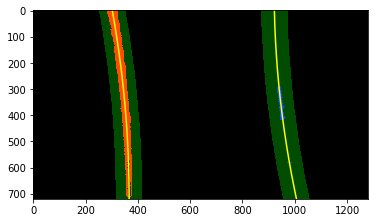

In [9]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Calculate both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx

result, left_fitx, right_fitx = search_around_poly(warped, left_fit, right_fit)
plt.imshow(result)

---
### Calculate the radius of curvature for the line of fit and the position of the vehicle with respect to the center of the lane.

The radius of curvature is calculated using the meters per pixel in the x and y axis as well as the polynomials of the lines calculated in the previous step.  The offset is calculated using the meters per pixel in the x direction, the intercepts of the polynomial lines with the x axis, and the middle of the image (640).

In [10]:
def measure_radius_of_curvature(x_values, img):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Generate some data to represent lane-line pixels
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])# to cover same y-range as image
    y_eval = np.max(ploty)

    # Fit a second order polynomial to pixel positions in the lane line
    fit_cr = np.polyfit(ploty * ym_per_pix, x_values * xm_per_pix, 2)    
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    return curverad

left_curve_rad = measure_radius_of_curvature(left_fitx, warped)
right_curve_rad = measure_radius_of_curvature(right_fitx, warped)
average_curve_rad = (left_curve_rad + right_curve_rad)/2

def measure_offset_from_center(right_fit, left_fit, img):
    # compute the offset from the center
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = 640 - (right_fitx[719] + left_fitx[719])/2
    return xm_per_pix*center_offset_pixels

offset_from_center = measure_offset_from_center(right_fit, left_fit, warped)

---
### Output original image with radius/position calculations and lane estimations.

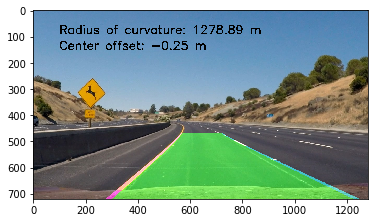

In [11]:
def draw_lane_info(img, bin_img, l_fit, r_fit, M_inv, radius, offset):
    # Copy image to draw on
    new_img = np.copy(img)
    
    warp_zero = np.zeros_like(bin_img)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = bin_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), [0,255, 0])
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    
    curvature_string = "Radius of curvature: %.2f m" % radius
    offset_string = "Center offset: %.2f m" % offset
    cv2.putText(result, curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), thickness=3)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), thickness=3)
    
    return result

plt.imshow(draw_lane_info(example_img, bin_img, left_fit, right_fit, M_inv, average_curve_rad, offset_from_center))

---
### Final Images Pipeline

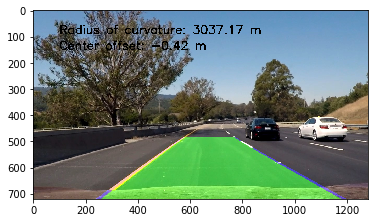

In [12]:
def image_pipeline(test_image):
    global mtx
    global dist
    
    undist = cv2.undistort(test_image, mtx, dist, None, mtx)
    # Image Undistorted

    b_thresh = (155, 200)
    l_thresh= (225, 255)

    l_channel = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)[:,:,1]
    b_channel = cv2.cvtColor(undist, cv2.COLOR_RGB2Lab)[:,:,2]
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.zeros_like(l_binary)
    color_binary[(l_binary == 1) | (b_binary == 1)] = 1
    # Binary Image created from undistorted image
    
    src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    dest = np.float32([[0, 0], [1280, 0],[1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dest)
    M_inv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(color_binary, M, (color_binary.shape[1], color_binary.shape[0]))
    # Perspective Transform performed on binary image

    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(warped))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(warped[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]

    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    # Histogram, sliding windows, and search from prior techniques used to find line of best fit for lanes
    
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)    
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)    
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty)*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty)*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius = (left_curverad + right_curverad) / 2
    # Radius of curvature calculated

    center_offset_pixels = 640 - (rightx_int + leftx_int)/2
    offset = xm_per_pix * center_offset_pixels
    # Offset from center calculated

    warp_zero = np.zeros_like(color_binary)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), [0,255, 0])
    cv2.polylines(color_warp, np.int32([pts]), isClosed=False, color=(0,0,255), thickness=20)

    newwarp = cv2.warpPerspective(color_warp, M_inv, (color_binary.shape[1], color_binary.shape[0])) 

    result = cv2.addWeighted(test_image, 1, newwarp, 0.5, 0)

    curvature_string = "Radius of curvature: %.2f m" % radius
    offset_string = "Center offset: %.2f m" % offset
    cv2.putText(result, curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), thickness=3)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), thickness=3)

    return result
        
plt.imshow(image_pipeline(plt.imread('./test_images/test6.jpg')))

---
### Example Video

In [13]:
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(image_pipeline)
white_clip.write_videofile('project_video_output.mp4', audio = False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:29<00:00,  4.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [14]:
%%HTML
<div align="middle">
<video width = "100%" controls>
      <source src="project_video_output.mp4" type="video/mp4">
</video></div>

---
### Discussion
#### Problems
* The video was taking a very long time to compile because I was calibrating the camera at each frame.  Creating global variables mtx and dest fixed that problem.
* Maintaining the desired image with proper image names was important throughout the pipeline to ensure the correct image is being processed when needed.
* The radius and offset calculations may be incorrect.  I was not sure how to correct/check my answers.
* Narrowing the range on the SobelX gradient improved performance of the pipeline significantly.
* The sliding window visualization was inconsistent in producing the windows.
* Have the window only look at the middle portion to avoid noise of nearby cars or barriers.

#### Failures
* Without quality lane lines near the vehicle.
* Vehicles over lane line or close to it.
* Barriers and shadows that look like lines.

#### Improvements
* Play around more with the different color spaces and constraints to maximize accuracy of the pipeline.
* Figuring out the exact measurements of the frame and decreasing the update frequency of the information displayed on the image (radius, offset).
* "Learn" from previous frames to avoid noisy frames.